In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import copy
import random
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [4]:
from resources.helper import PeakData, Isotopes
known_cys_fnam = 'resources/known_cys_labeled.tab'
known_gln_fnam = 'resources/known_gln_labeled.tab'
# blacklist_fnam = 'resources/blacklist.tab'
blacklist_fnam = 'resources/blacklist-GSH-artifacts.tab'

# Read isotope information into an object:
IUPAC_atomic_masses = 'resources/IUPAC-atomic-masses.csv'
IUPAC_atomic_abundances = 'resources/IUPAC-atomic-abundances.html'
isotope_obj = Isotopes(IUPAC_atomic_masses, IUPAC_atomic_abundances)

# Adducts:
adducts_fnam = 'resources/adducts.tab'

## Define default parameters for peak filtering and peak pair finding

In [5]:
params = {
    ### Specify the formula for the isotopes in the labels used ###
    'labels': {
        'cys': '[13]C3 [15]N',
        'gly': '[13]C2',
        'gln': '[13]C5'
    },
    # End of isotope specification ################################

    ### Peak filter parameters ###
    'min_area': 25000,        # minimum peak area for at least one sample
    'min_MW': 120,            # minimum molecular weight of a compound (120 is one Da below Cysteine)
    'min_fold_blank': 4,      # minimum sample to blank peak area ratio
                              # i.e. max(sample)/max(blank) > min_fold_blank

    # Peak filter: peak merging #
    # Merge peaks within a ppm mass distance AND within
    # a retention time difference OR a retention time difference x2
    # AND over a minimum peak area correlation coefficient
    'merge_ppm_tol': 50,      # maximum mass distance (in ppm) between peaks to merge
    'merge_RT_tol': 0.1,      # maximum retention time difference between peaks to merge
    'merge_corr_tol':0.9,     # minimum peak area correlation coefficient
    # End of peak filter #########
    
    ### Peak pair finding ###
    'pair_ppm_tol': 10,            # maximum mass distance (in ppm) of expected mass shift between pairs
    'pair_RT_tol': 0.25,           # maximum retention time difference between pairs
    'pair_min_area': 1,            # minimum number of sample that pass the area ratio criterium

    # Range, or list of ranges, of labelled to unlabelled peak area ratios
    # within the accepted cutoff (ratio = labelled / sum(labelled, unlabelled))
    # These ratios are adjusted on an experiment-to-experiment basis (see below examples).
    'area_ratio_cutoff': {
        'cys': ((0.2, 0.28),
                (0.34, 0.42)),  # GSSG theoretical parent/(parent+heavy) is 0.25 with 50/50 labelled
        'gly': ((0.08, 0.24),),
        'gln': ((0.18, 0.6),),
    },
    # End of pair finding ###
    
    ### Peak pair filter parameters ###
    # Pair filter: adduct flagging #
    # Flag an adduct if it is within a ppm mass distance
    # and within a retention time difference
    # and has smaller total peak area than its parent ion
    'adduct_ppm_tol': 200,     # maximum mass distance (in ppm) to call adduct
    'adduct_RT_tol': 0.8,      # maximum retention time difference to call adduct

    # Pair filter: isotope flagging #
    # Flag an isotope if it is within a ppm mass distance
    # and within a retention time difference
    # and has a minimum peak area correlation coefficient
    # and has smaller total peak area than its parent ion
    'isotope_ppm_tol': 200,     # maximum mass distance (in ppm) to call isotope
    'isotope_RT_tol': 0.4,      # maximum retention time difference to call isotope
    'isotope_corr_tol':0.7,     # minimum peak area correlation coefficient to call isotope
    # End of peak pair filter #########

}

# Calculate the mass shift for each label:
params['MW_shift'] = dict()
for label in params['labels']:
    params['MW_shift'][label] = isotope_obj.isotopes2mass_shift(params['labels'][label])
print('Calculated mass shift for entered labels:')
pp.pprint(params['MW_shift'])

Calculated mass shift for entered labels:
{'cys': 4.007099400040005,
 'gln': 5.016774176699997,
 'gly': 2.0067096706799994}


## Cysteine tracing on NRF2 on/off cancer cell lines

Anna.

Put description here.


In [6]:
# Excel data filenames:
datafile_pos = 'projects/bile-duct-cells_cys-tracing/pos/bile-duct-cells_cys-tracing_pos.xlsx'
datafile_neg = 'projects/bile-duct-cells_cys-tracing/neg/bile-duct-cells_cys-tracing_neg.xlsx'

# Input information:
input_desc_fnam = 'projects/bile-duct-cells_cys-tracing/bile-duct-cells_cys-tracing.json'
# Since comments are not allowed in JSON format
# Use the eval function to turn this pseudo JSON into a dictionary:
input_desc = eval(open(input_desc_fnam, 'r').read())

# Read the data:
peak_obj = PeakData('bile-duct-cells_cys-tracing', input_desc, params)

# Adjust parameters according to the samples processing:
peak_obj.params['min_area'] = 6000

# Read peaks:
peak_obj.read_peaks(datafile_pos, 'pos')
peak_obj.read_peaks(datafile_neg, 'neg')

# Annotate known peaks:
peak_obj.annotate_known_peaks(known_cys_fnam, isotope_obj.formula2mass)

Running peak filtering for polarity: pos
Filtered 6446 peaks out based on.
Minimum peak area: 1732
Minimum molecular weight: 1311
Minimum fold over blank: 2933
Merged closely related peaks: 470
4895 peaks left.

Running peak filtering for polarity: neg
Filtered 3631 peaks out based on.
Minimum peak area: 957
Minimum molecular weight: 624
Minimum fold over blank: 1627
Merged closely related peaks: 423
4153 peaks left.



### Adjust parameters for peak pair finding

In [7]:
# Find labelling ratio for known cysteine labelled
# compounds in positive polarity:
peak_obj.pick_ratio(known_cys_fnam, 'pos', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),R5P Cys (m),R5P Cys (m+4),G3P Cys (m),G3P Cys (m+4),Cysteine (m),Cysteine (m+4),DHAP Cys (m),DHAP Cys (m+4),G6P Cys (m),G6P Cys (m+4),Glutamylcysteine (m),Glutamylcysteine (m+4),Succinylcysteine (m),Succinylcysteine (m+4),Succinylglutathione (m),Succinylglutathione (m+4),Conjugate EC = C3H3O2 (m),Conjugate EC = C3H3O2 (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4),GSH conjugate EC = C4H10NO (m),GSH conjugate EC = C4H10NO (m+4)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0,45.0
mean,0.712549,0.287451,0.589218,0.410782,0.184433,0.815567,0.671889,0.328111,0.651214,0.348786,0.671889,0.328111,0.683610,0.316390,0.621665,0.378335,0.776928,0.223072,0.803794,0.196206,0.654254,0.345746,0.731855,0.268145,0.5,0.5
std,0.034952,0.034952,0.064082,0.064082,0.284033,0.284033,0.066510,0.066510,0.098866,0.098866,0.066510,0.066510,0.065081,0.065081,0.131029,0.131029,0.063004,0.063004,0.063950,0.063950,0.127499,0.127499,0.042869,0.042869,0.0,0.0
min,0.653260,0.220390,0.451534,0.286527,0.002299,0.058153,0.478233,0.170030,0.350044,0.166609,0.478233,0.170030,0.485017,0.173478,0.250029,0.139770,0.598357,0.107654,0.686118,0.092368,0.181453,0.158535,0.669887,0.166431,0.5,0.5
25%,0.680949,0.259468,0.546732,0.362781,0.015202,0.786299,0.658281,0.293020,0.582551,0.285234,0.658281,0.293020,0.644382,0.265434,0.478083,0.306609,0.733455,0.178331,0.751198,0.142111,0.628913,0.279547,0.696197,0.244463,0.5,0.5
50%,0.711727,0.288273,0.584386,0.415614,0.034857,0.965143,0.680555,0.319445,0.671617,0.328383,0.680555,0.319445,0.668309,0.331691,0.637276,0.362724,0.772125,0.227875,0.797872,0.202128,0.683955,0.316045,0.726821,0.273179,0.5,0.5
75%,0.740532,0.319051,0.637219,0.453268,0.213701,0.984798,0.706980,0.341719,0.714766,0.417449,0.706980,0.341719,0.734566,0.355618,0.693391,0.521917,0.821669,0.266545,0.857889,0.248802,0.720453,0.371087,0.755537,0.303803,0.5,0.5
max,0.779610,0.346740,0.713473,0.548466,0.941847,0.997701,0.829970,0.521767,0.833391,0.649956,0.829970,0.521767,0.826522,0.514983,0.860230,0.749971,0.892346,0.401643,0.907632,0.313882,0.841465,0.818547,0.833569,0.330113,0.5,0.5


In [8]:
# Find labelling ratio for known cysteine labelled
# compounds in negative polarity:
peak_obj.pick_ratio(known_cys_fnam, 'neg', isotope_obj.formula2mass, 'cys', ['m', 'm+4'])

,GSH (m),GSH (m+4),GSSG (m),GSSG (m+4),S-Lactoylglutathione (m),S-Lactoylglutathione (m+4),S-(Formylmethyl)glutathione (m),S-(Formylmethyl)glutathione (m+4),R5P Cys (m),R5P Cys (m+4),G3P Cys (m),G3P Cys (m+4),Cysteine (m),Cysteine (m+4),DHAP Cys (m),DHAP Cys (m+4),G6P Cys (m),G6P Cys (m+4),Glutamylcysteine (m),Glutamylcysteine (m+4),Succinylcysteine (m),Succinylcysteine (m+4),Succinylglutathione (m),Succinylglutathione (m+4),Conjugate EC = C3H3O2 (m),Conjugate EC = C3H3O2 (m+4),Cysteinylglycine (m),Cysteinylglycine (m+4)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.708579,0.291421,0.732336,0.267664,0.720002,0.279998,0.774812,0.225188,0.706340,0.293660,0.664104,0.335896,0.754861,0.245139,0.664104,0.335896,0.568109,0.431891,0.739299,0.260701,0.767598,0.232402,0.781089,0.218911,0.631690,0.368310,0.737456,0.262544
std,0.037188,0.037188,0.082662,0.082662,0.152445,0.152445,0.108271,0.108271,0.050754,0.050754,0.205203,0.205203,0.083875,0.083875,0.205203,0.205203,0.150915,0.150915,0.086749,0.086749,0.082595,0.082595,0.097497,0.097497,0.081550,0.081550,0.055188,0.055188
min,0.650689,0.192654,0.566008,0.076575,0.355485,0.077509,0.452230,0.054225,0.628487,0.086211,0.251665,0.026578,0.480253,0.102029,0.251665,0.026578,0.278067,0.144058,0.564116,0.114001,0.571985,0.089754,0.523808,0.053381,0.494626,0.197446,0.626977,0.170564
25%,0.675649,0.264943,0.674670,0.228054,0.634923,0.176625,0.725785,0.144507,0.690690,0.305055,0.451865,0.190582,0.732231,0.200298,0.451865,0.190582,0.419821,0.304568,0.662928,0.189964,0.719766,0.166635,0.734817,0.153035,0.593264,0.311117,0.695593,0.227082
50%,0.707625,0.292375,0.715324,0.284676,0.779509,0.220491,0.776359,0.223641,0.690690,0.309310,0.710282,0.289718,0.740987,0.259013,0.710282,0.289718,0.574126,0.425874,0.746146,0.253854,0.751476,0.248524,0.803317,0.196683,0.648176,0.351824,0.742551,0.257449
75%,0.735057,0.324351,0.771946,0.325330,0.823375,0.365077,0.855493,0.274215,0.694945,0.309310,0.809418,0.548135,0.799702,0.267769,0.809418,0.548135,0.695432,0.580179,0.810036,0.337072,0.833365,0.280234,0.846965,0.265183,0.688883,0.406736,0.772918,0.304407
max,0.807346,0.349311,0.923425,0.433992,0.922491,0.644515,0.945775,0.547770,0.913789,0.371513,0.973422,0.748335,0.897971,0.519747,0.973422,0.748335,0.855942,0.721933,0.885999,0.435884,0.910246,0.428015,0.946619,0.476192,0.802554,0.505374,0.829436,0.373023


In [9]:
# Based on above analysis the cutoff is chosen:
peak_obj.params['area_ratio_cutoff']['cys'] = ((0.05, 0.90),)

# RT and MW tolerances are also adjusted:
peak_obj.params['pair_ppm_tol'] = 5
peak_obj.params['pair_RT_tol'] = 0.25

### Search for peak pairs and flag isotopes, adducts etc

In [10]:
# Find pairs:
peak_obj.find_pairs('pos')
peak_obj.find_pairs('neg')

In [11]:
# Flag inferred adducts and blacklisted compounds
# in the peak pairs:
peak_obj.flag_blacklist(blacklist_fnam, polarity='both')
peak_obj.flag_adducts(adducts_fnam, polarity='both')

In [12]:
# Generate isotopic mass shift combinations:
isotope_set = isotope_obj.find_iso_set(min_abs=1e-6)
pp.pprint(isotope_set)

{('[13]C',): {'abundance': 0.010599999999999998,
              'mass_shift': 1.0033548353399997},
 ('[13]C', '[13]C'): {'abundance': 0.00011235999999999996,
                      'mass_shift': 2.0067096706799994},
 ('[13]C', '[13]C', '[13]C'): {'abundance': 1.1910159999999995e-06,
                               'mass_shift': 3.010064506020001},
 ('[13]C', '[13]C', '[34]S'): {'abundance': 4.9045139999999985e-06,
                               'mass_shift': 4.00250550813999},
 ('[13]C', '[15]N'): {'abundance': 4.022699999999999e-05,
                      'mass_shift': 2.000389729360002},
 ('[13]C', '[15]N', '[34]S'): {'abundance': 1.7559085499999997e-06,
                               'mass_shift': 3.996185566820003},
 ('[13]C', '[17]O'): {'abundance': 4.065099999999999e-06,
                      'mass_shift': 2.00757197203},
 ('[13]C', '[18]O'): {'abundance': 2.1676999999999996e-05,
                      'mass_shift': 3.007599828220002},
 ('[13]C', '[2]H'): {'abundance': 1.5369999999999

In [13]:
# Flag isotopes in the peak pairs:
peak_obj.flag_isotopes(isotope_set, polarity='both')

In [14]:
# Write results as Excel files:
peak_obj.write_pairs('projects/bile-duct-cells_cys-tracing/pos/bile-duct-cells_cys-tracing_pairs_pos', 'pos')
peak_obj.write_pairs('projects/bile-duct-cells_cys-tracing/neg/bile-duct-cells_cys-tracing_pairs_neg', 'neg')

### Processing the results

At this point, all the results have been written to Excel files which provide an interface to further processing/filtering/plotting.

In the following, I will show another way of processing the results and show some of the findings that can be extracted from the data.

In [15]:
# Extract sample information from the input description JSON
# stored in the "group" tag:
name2info = {desc['name']: desc for desc in input_desc.values() if desc['type'] != 'blank'}
sample_info_df = pd.DataFrame.from_dict(name2info, orient='index')
sample_info_df[['Cell_line','Genotype']] = sample_info_df.group.str.split(', ', expand=True)
sample_info_df.head(4)

,name,order,type,label,group,Cell_line,Genotype
CCLP_1,CCLP_1,19,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
CCLP_2,CCLP_2,20,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
CCLP_3,CCLP_3,21,sample,cys,"CCLP, bile-duct-NRF2-off",CCLP,bile-duct-NRF2-off
SSP25_1,SSP25_1,7,sample,cys,"SSP25, bile-duct-NRF2-on",SSP25,bile-duct-NRF2-on


In [16]:
# We start in positive polarity by grabbing the peak pairs from cystine tracing:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
df_pos.head(4)

,pair_id,MW_parent,RT_parent,MW_heavy,RT_heavy,polarity,label,name,RT_diff,MW_ppm_diff,Isotopes,Adducts,Blacklist,known_anno,KKU100_1,KKU100_2,KKU100_3,SNU308_1,SNU308_2,SNU308_3,SSP25_1,SSP25_2,SSP25_3,TFK_1,TFK_2,...,CCLP_3,RBE_1,RBE_2,RBE_3,ICC2_1,ICC2_2,ICC2_3,TGBC_1,TGBC_2,TGBC_3,SNU1196_1,SNU1196_2,SNU1196_3,UOK262_1,UOK262_2,UOK262_3,A549_1,A549_2,A549_3,NRF2-const_dox_1,NRF2-const_dox_2,NRF2-const_dox_3,NRF2-const_vec_1,NRF2-const_vec_2,NRF2-const_vec_3
0,"((121.01976, 8.628), (125.02687, 8.644), pos, ...",121.02,8.628,125.027,8.644,pos,cys,Cysteine,0.016,0.0875887,None,None,None,Cysteine,133334,151376,142098,30856.9,25858.9,25844.4,283553,212475,322239,119188,144163,...,4727.89,7261.28,6667.85,6476.08,6369.32,8649.56,3877.17,24261.6,26243.3,25143.7,16294.3,27141.5,24632.2,20954.5,14470.4,18220.8,67603.5,68020,49325.9,1291.83,1231.27,1398.05,1204.66,1277.89,1174.99
1,"((127.09964, 7.163), (131.10682, 7.155), pos, ...",127.1,7.163,131.107,7.155,pos,cys,1-Methyl-2-azepanone,0.008,0.634148,None,"[(5, M+3ACN+2H), (6, M+3ACN+2H), (7, M+3ACN+2H)]",None,None,2167,1640.94,1906.26,1154.12,779.089,958.661,279.68,665.481,285.668,607.131,344.16,...,350.575,2637.41,1463.53,2364.65,347.41,2409.45,2730.51,950.864,1664.28,3860.28,1431.33,1990.99,1662.74,1788.17,1750.04,2178.89,2795.91,3011.52,2513.43,7735.54,6296.98,4642.58,7437.56,6441.82,6718.15
2,"((128.0586, 9.689), (132.06581, 9.563), pos, cys)",128.059,9.689,132.066,9.563,pos,cys,Dihydrothymine,0.126,0.863667,None,None,None,None,741928,1.02226e+06,1.04907e+06,6.34795e+06,6.51515e+06,6.62268e+06,956124,900244,1.05235e+06,1.44152e+07,1.32337e+07,...,9.67889e+06,3.53472e+06,3.3926e+06,3.40775e+06,2.61702e+06,3.18634e+06,2.70341e+06,3.30049e+06,3.13197e+06,3.05302e+06,1.62697e+07,1.55206e+07,1.4871e+07,7.40348e+06,7.29639e+06,7.30958e+06,3.10315e+06,3.49961e+06,3.5575e+06,1.73833e+07,1.64538e+07,1.56411e+07,1.88918e+07,1.57477e+07,1.72123e+07
3,"((129.04948, 9.867), (133.05679, 10.054), pos,...",129.049,9.867,133.057,10.054,pos,cys,NaN,0.187,1.63193,None,"[(34, M+2ACN+2H)]",None,None,4417.75,1923.3,7351.96,10441.1,8382.82,9674.87,16889.4,6863.8,14307.1,9239.56,5876.51,...,12792.9,25034.2,13076.5,15920.8,10800.1,4805.33,10315.1,900.825,1008.37,797.065,2341.46,12701.8,6234.75,8501.56,10479.1,13012.1,12367.1,6673.25,8743.54,2611.91,2622.06,2461.31,1844.02,1797.63,1764.31


In [17]:
def flat_df(df_pol, sample_info_df):
    # Now let's get rid of the adducts, isotopes and blacklisted peaks:
    mask = (df_pol['Isotopes'].isnull() & df_pol['Adducts'].isnull() & df_pol['Blacklist'].isnull()) | ~df_pol['known_anno'].isnull()
    df_pol = df_pol[mask]

    # And flatten the data for easy sorting/filtering/plotting:
    df_pol_flat = pd.melt(df_pol, id_vars=['MW_parent', 'RT_parent', 'Adducts', 'known_anno'], value_vars=list(name2info.keys()), var_name='sample', value_name='area')
    # Add MW_RT string:
    df_pol_flat['MW_RT_anno'] = [str(mw)+'_'+str(rt)+'_'+str(anno) for mw, rt, anno in zip(df_pol_flat['MW_parent'].values, df_pol_flat['RT_parent'].values, df_pol_flat['known_anno'].values)]
    # Add sample info:
    df_pol_flat = df_pol_flat.merge(sample_info_df.loc[:, ['name', 'Cell_line', 'Genotype']], left_on='sample', right_on='name')
    # Drop unnecessary columns:
    df_pol_flat = df_pol_flat.drop(['name'], axis=1)

    return(df_pol, df_pol_flat)

df_pos, df_pos_flat = flat_df(df_pos, sample_info_df)
df_pos_flat.head(3)

,MW_parent,RT_parent,Adducts,known_anno,sample,area,MW_RT_anno,Cell_line,Genotype
0,121.02,8.628,None,Cysteine,CCLP_1,1020.62,121.01976_8.628_Cysteine,CCLP,bile-duct-NRF2-off
1,128.059,9.689,None,None,CCLP_1,8.63537e+06,128.0586_9.689_None,CCLP,bile-duct-NRF2-off
2,131.047,9.779,None,None,CCLP_1,1.11183e+06,131.04677_9.779_None,CCLP,bile-duct-NRF2-off


In [18]:
# Data, no label:
df_pos = peak_obj.label_pairs['cys']['pos']['peak_pair_area_parent'].copy()
mask = (df_pos['Isotopes'].isnull() & df_pos['Adducts'].isnull() & df_pos['Blacklist'].isnull()) | ~df_pos['known_anno'].isnull()
df_pos, df_pos_flat = flat_df(df_pos[mask], sample_info_df)

# Data, cysteine label (m+4):
df_pos_m4 = peak_obj.label_pairs['cys']['pos']['peak_pair_area_heavy'].copy()
mask = (df_pos_m4['Isotopes'].isnull() & df_pos_m4['Adducts'].isnull() & df_pos_m4['Blacklist'].isnull()) | ~df_pos_m4['known_anno'].isnull()
df_pos_m4, df_pos_flat_m4 = flat_df(df_pos_m4[mask], sample_info_df)

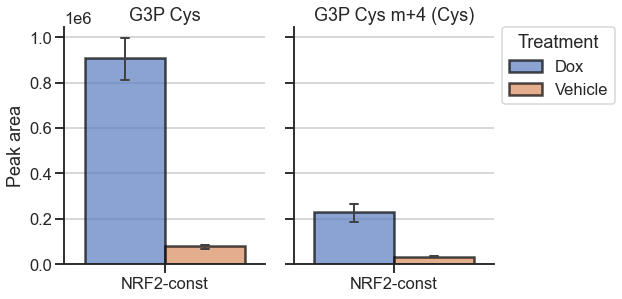

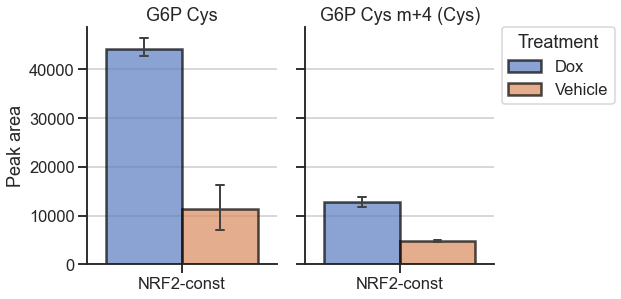

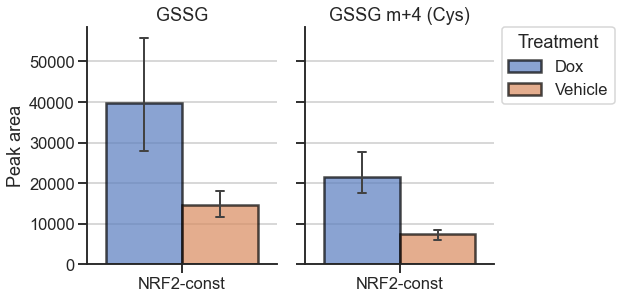

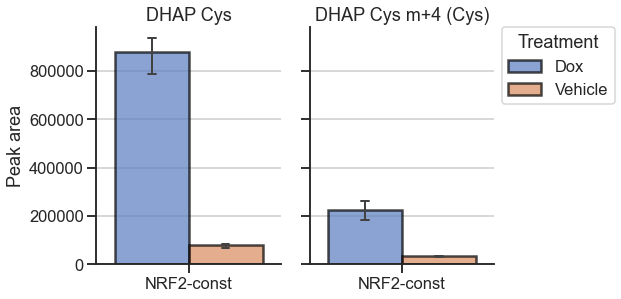

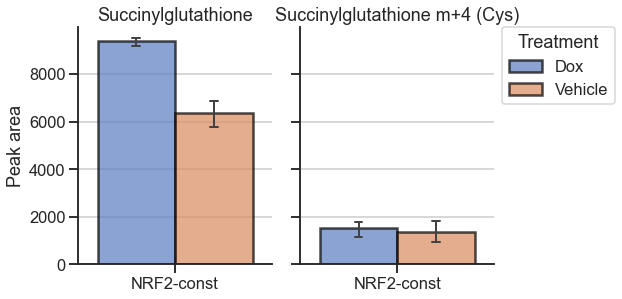

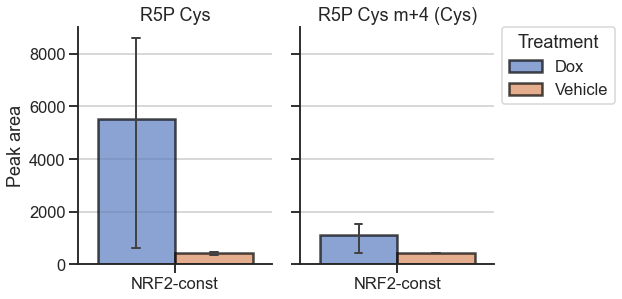

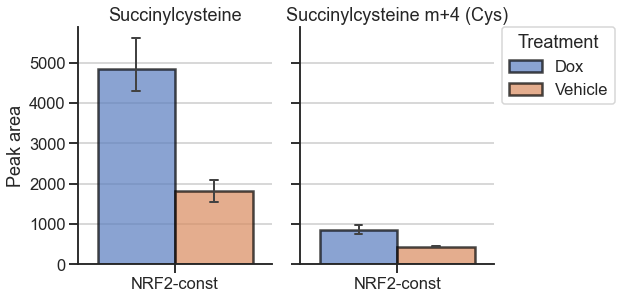

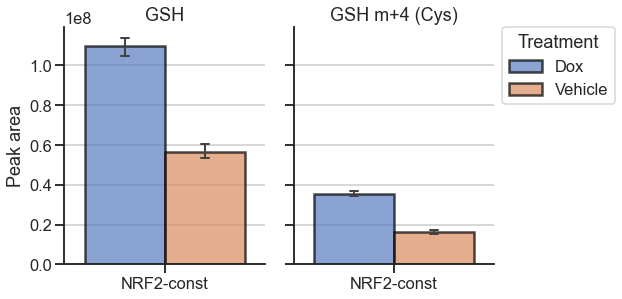

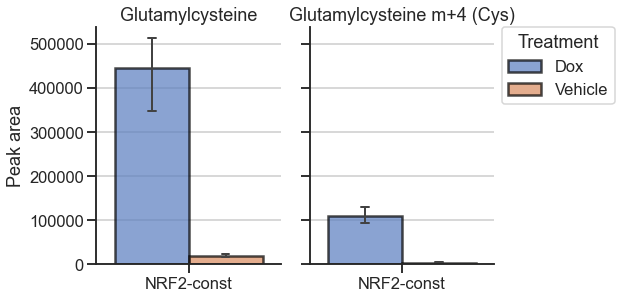

In [19]:
# Plotting, H1299 NRF2 constitutive:
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/H1299-NRF2-constitutive'
exclusion_set = {'616.15952_11.875_GSSG', '307.08318_9.619_GSH', '307.08353_11.933_GSH', '307.08367_11.184_GSH', '121.01976_8.628_Cysteine', '178.04112_7.001_Cysteinylglycine', '178.04115_9.959_Cysteinylglycine', '178.04116_10.47_Cysteinylglycine', '191.02504_10.377_Conjugate EC = C3H3O2', '283.07244_9.331_G6P Cys'}
for peak_id in set(df_pos_flat[~df_pos_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] == 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Cell_line', hue='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id) & (df_pos_flat_m4['Cell_line'] == 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Cell_line', hue='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_NRF2-const.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

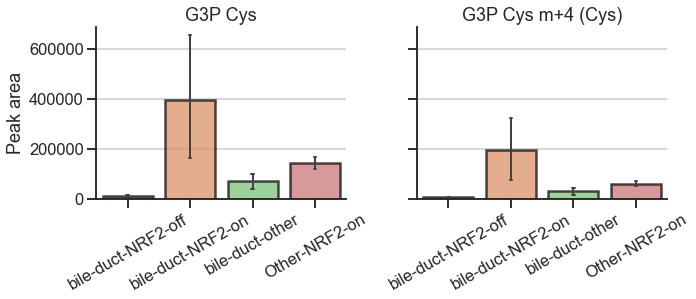

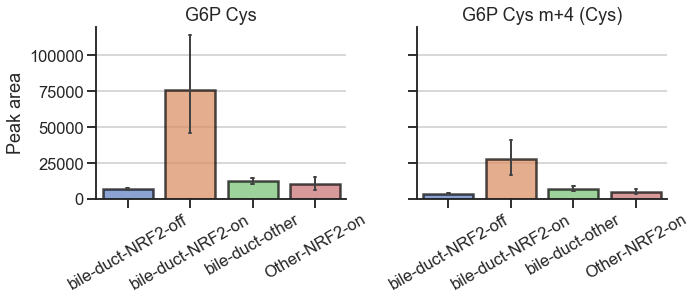

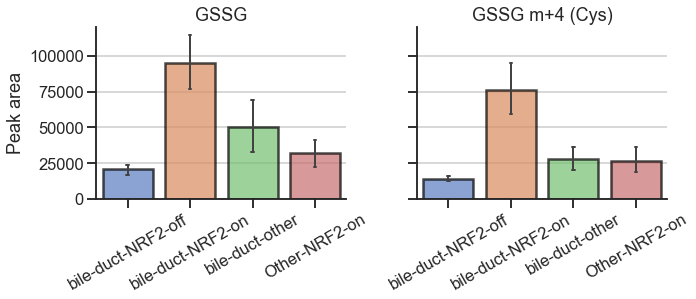

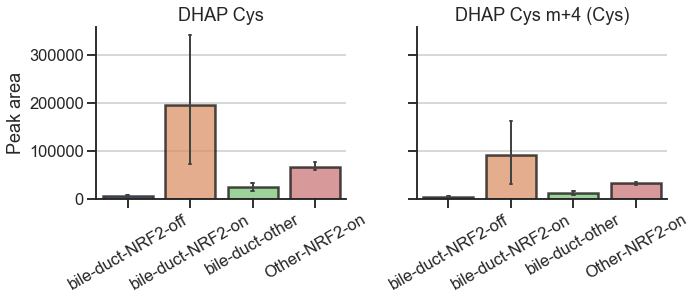

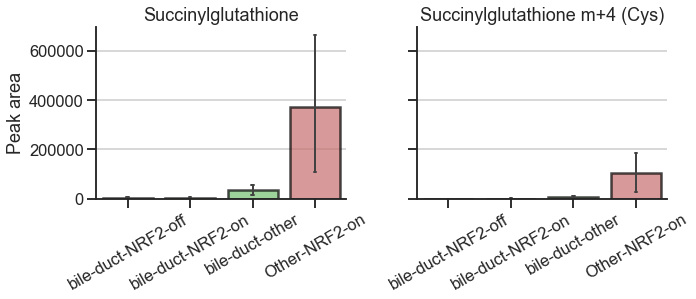

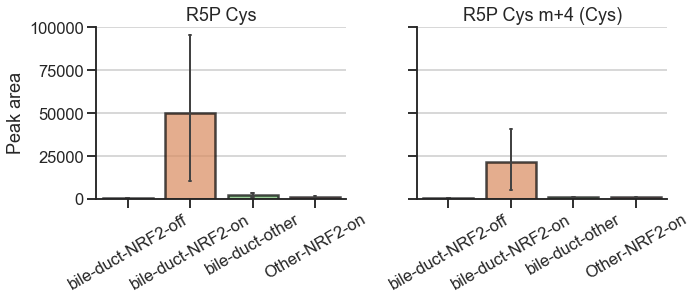

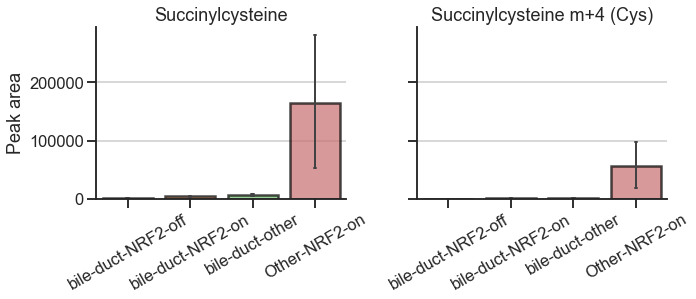

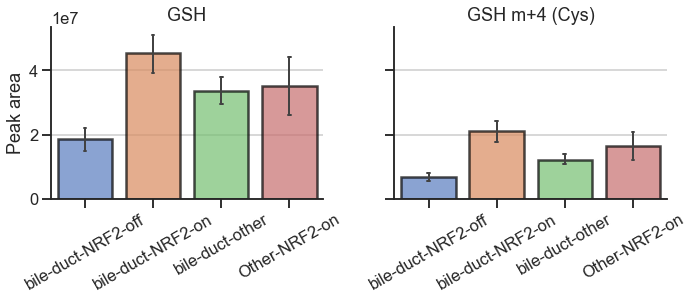

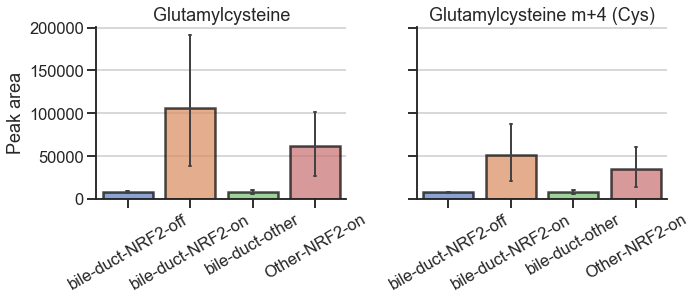

In [20]:
# Plotting, bile duct cells comparison:
plot_fld = 'projects/bile-duct-cells_cys-tracing/pos/plots/bile-duct-comparison'
exclusion_set = {'616.15952_11.875_GSSG', '307.08318_9.619_GSH', '307.08353_11.933_GSH', '307.08367_11.184_GSH', '121.01976_8.628_Cysteine', '178.04112_7.001_Cysteinylglycine', '178.04115_9.959_Cysteinylglycine', '178.04116_10.47_Cysteinylglycine', '191.02504_10.377_Conjugate EC = C3H3O2', '283.07244_9.331_G6P Cys'}
for peak_id in set(df_pos_flat[~df_pos_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

    ### No label:
    mask = (df_pos_flat['MW_RT_anno'] == peak_id) & (df_pos_flat['Cell_line'] != 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_pos_flat[mask], y='area', x='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    ### Cysteine label (m+4):
    mask = (df_pos_flat_m4['MW_RT_anno'] == peak_id) & (df_pos_flat_m4['Cell_line'] != 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_pos_flat_m4[mask], y='area', x='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name))
    g2.grid(True, axis='y')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=30)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

In [22]:
# Data, no label:
df_neg = peak_obj.label_pairs['cys']['neg']['peak_pair_area_parent'].copy()
mask = (df_neg['Isotopes'].isnull() & df_neg['Adducts'].isnull() & df_neg['Blacklist'].isnull()) | ~df_neg['known_anno'].isnull()
df_neg, df_neg_flat = flat_df(df_neg[mask], sample_info_df)

# Data, cysteine label (m+4):
df_neg_m4 = peak_obj.label_pairs['cys']['neg']['peak_pair_area_heavy'].copy()
mask = (df_neg_m4['Isotopes'].isnull() & df_neg_m4['Adducts'].isnull() & df_neg_m4['Blacklist'].isnull()) | ~df_neg_m4['known_anno'].isnull()
df_neg_m4, df_neg_flat_m4 = flat_df(df_neg_m4[mask], sample_info_df)

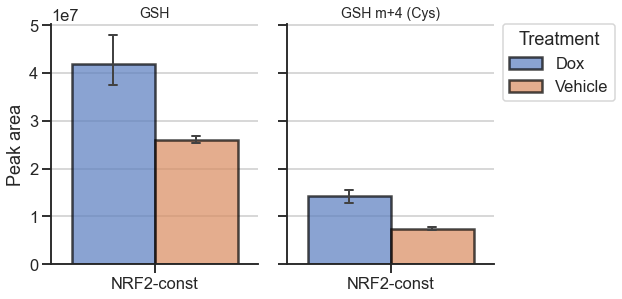

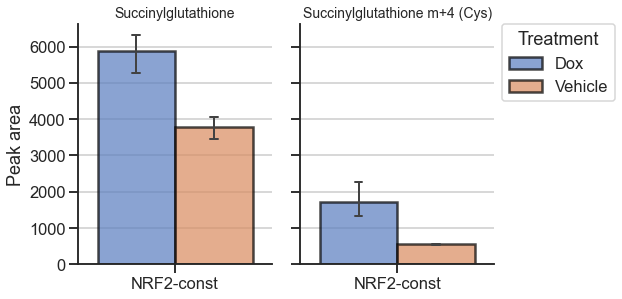

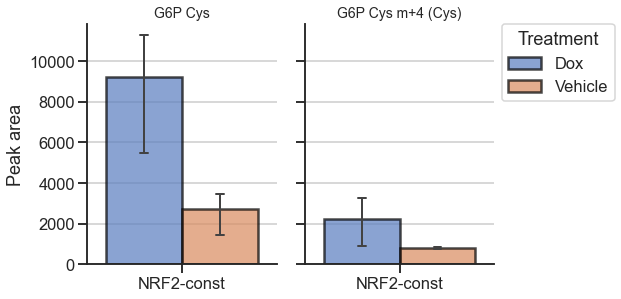

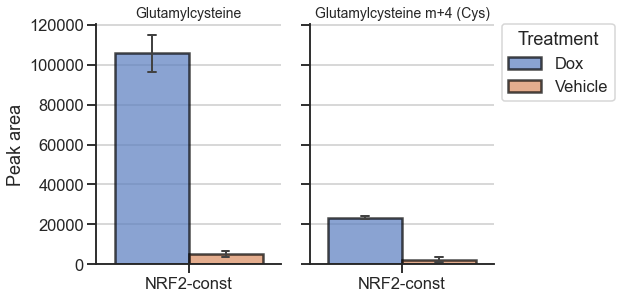

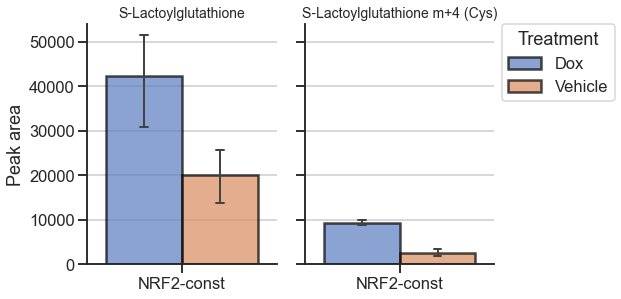

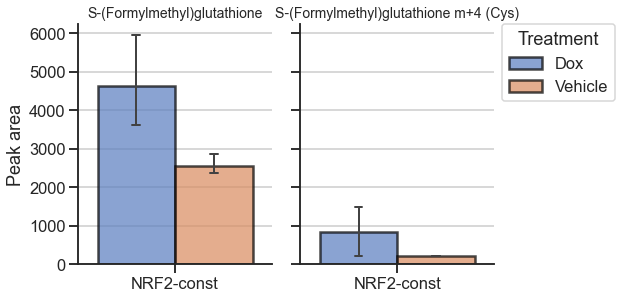

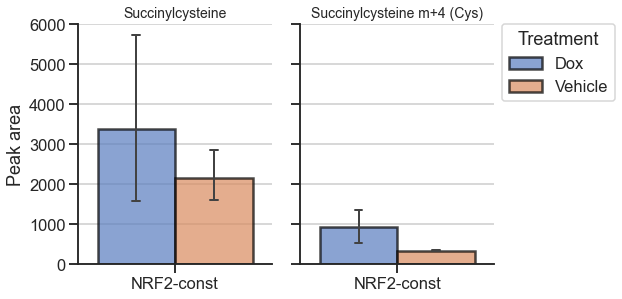

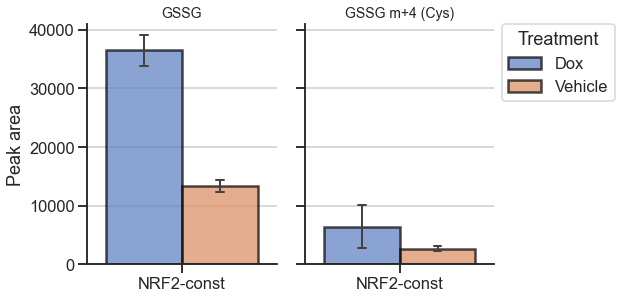

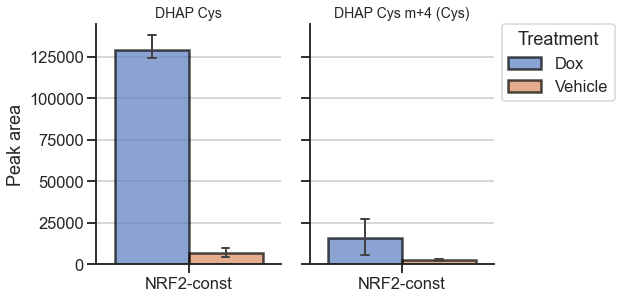

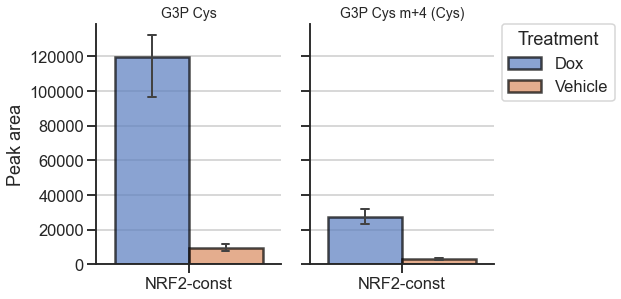

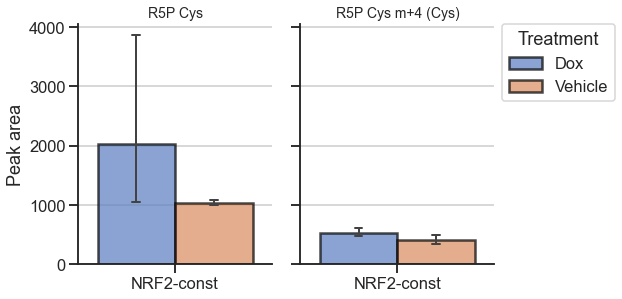

In [23]:
# Plotting, H1299 NRF2 constitutive:
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/H1299-NRF2-constitutive'
exclusion_set = {'121.01974_8.649_Cysteine', '178.04111_9.928_Cysteinylglycine', '191.0251_10.38_Conjugate EC = C3H3O2', '178.04106_7.037_Cysteinylglycine', '307.08328_11.074_GSH', '307.08342_11.458_GSH', '307.08344_11.766_GSH', '307.08344_8.935_GSH', '307.08351_12.08_GSH', '307.08353_12.517_GSH', '307.08355_9.474_GSH', '307.08359_8.744_GSH', '307.0835_11.223_GSH', '307.08363_10.8_GSH', '307.08454_9.805_GSH', '616.15882_11.862_GSSG', '612.15112_12.033_GSSG', '193.04086_5.143_DHAP Cys'}
for peak_id in set(df_neg_flat[~df_neg_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] == 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Cell_line', hue='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.legend_.remove()

    ### Cysteine label (m+4):
    mask = (df_neg_flat_m4['MW_RT_anno'] == peak_id) & (df_neg_flat_m4['Cell_line'] == 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_neg_flat_m4[mask], y='area', x='Cell_line', hue='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name), size=14)
    g2.grid(True, axis='y')
    g2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Treatment', loc='upper left')
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_NRF2-const.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig

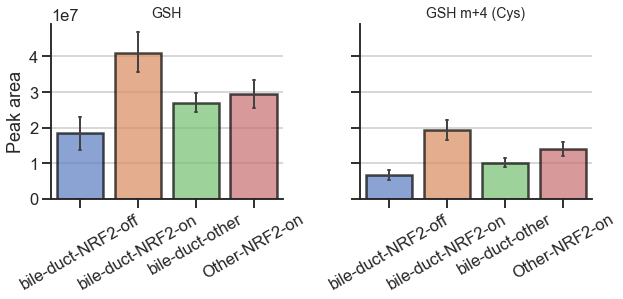

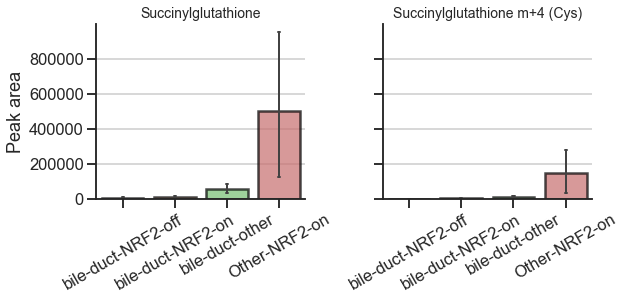

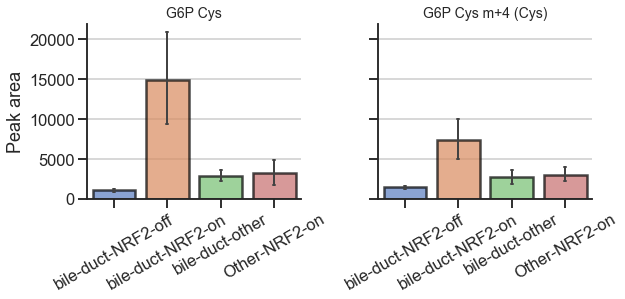

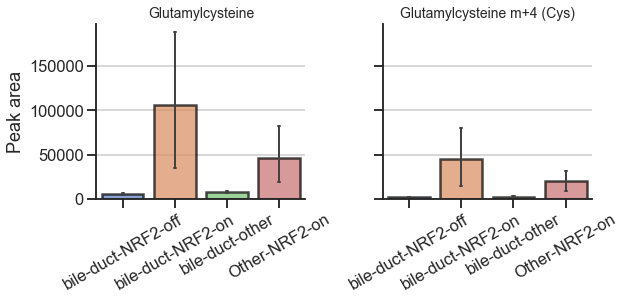

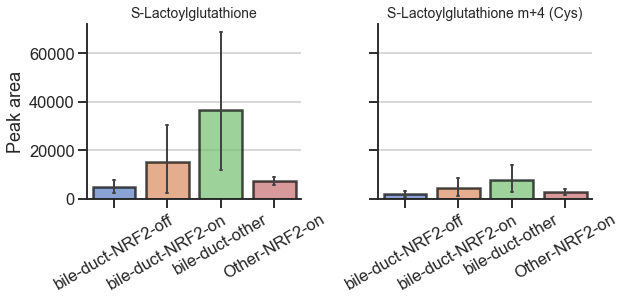

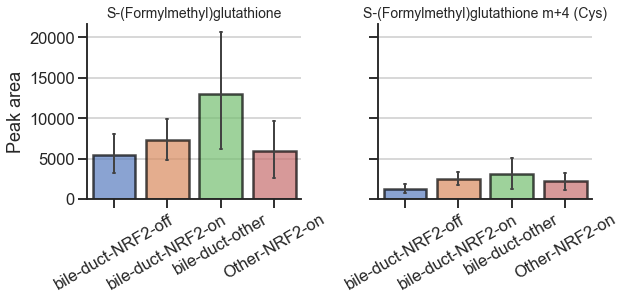

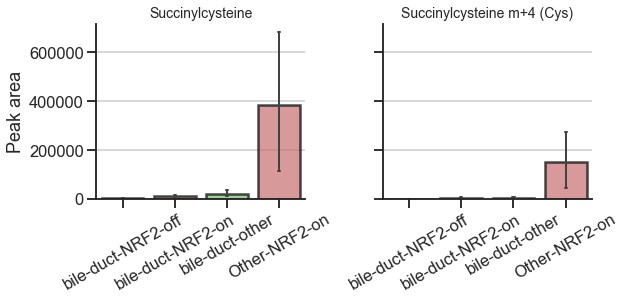

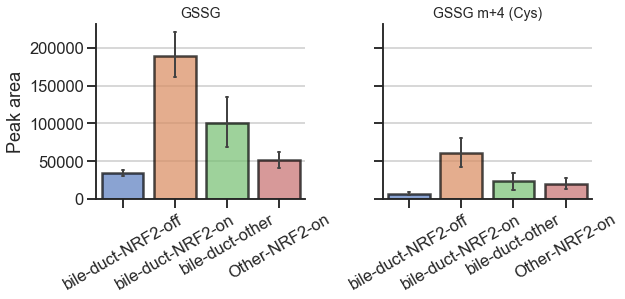

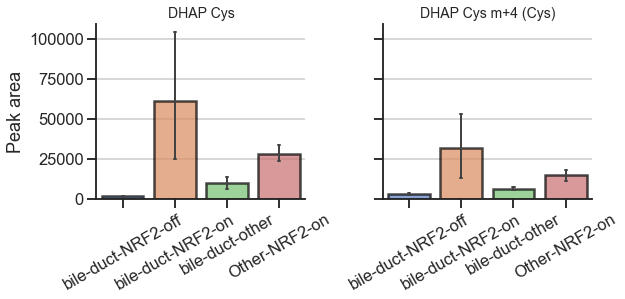

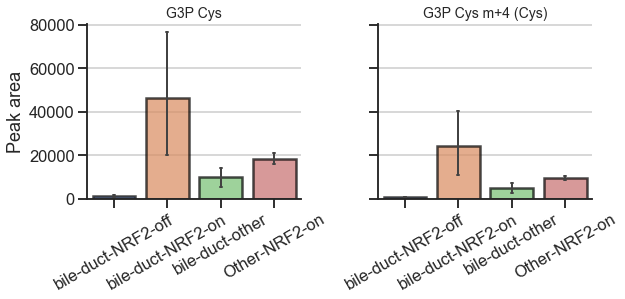

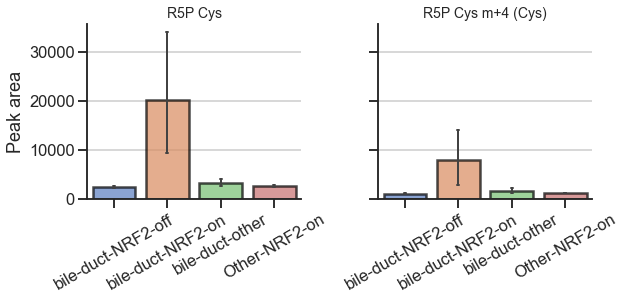

In [24]:
# Plotting, bile duct cells comparison:
plot_fld = 'projects/bile-duct-cells_cys-tracing/neg/plots/bile-duct-comparison'
exclusion_set = {'121.01974_8.649_Cysteine', '178.04111_9.928_Cysteinylglycine', '191.0251_10.38_Conjugate EC = C3H3O2', '178.04106_7.037_Cysteinylglycine', '307.08328_11.074_GSH', '307.08342_11.458_GSH', '307.08344_11.766_GSH', '307.08344_8.935_GSH', '307.08351_12.08_GSH', '307.08353_12.517_GSH', '307.08355_9.474_GSH', '307.08359_8.744_GSH', '307.0835_11.223_GSH', '307.08363_10.8_GSH', '307.08454_9.805_GSH', '616.15882_11.862_GSSG', '612.15112_12.033_GSSG', '193.04086_5.143_DHAP Cys'}
for peak_id in set(df_neg_flat[~df_neg_flat['known_anno'].isnull()]['MW_RT_anno']):
    if peak_id in exclusion_set:
        continue
    name = peak_id.split('_')[-1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True)

    ### No label:
    mask = (df_neg_flat['MW_RT_anno'] == peak_id) & (df_neg_flat['Cell_line'] != 'NRF2-const')
    g1 = sns.barplot(ax=ax1, data=df_neg_flat[mask], y='area', x='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g1.set_xlabel('')
    g1.set_ylabel('Peak area')
    g1.set_title(name, size=14)
    g1.grid(True, axis='y')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

    ### Cysteine label (m+4):
    mask = (df_neg_flat_m4['MW_RT_anno'] == peak_id) & (df_neg_flat_m4['Cell_line'] != 'NRF2-const')
    g2 = sns.barplot(ax=ax2, data=df_neg_flat_m4[mask], y='area', x='Genotype', ci=95, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
    g2.set_xlabel('')
    g2.set_ylabel('')
    g2.set_title('{} m+4 (Cys)'.format(name), size=14)
    g2.grid(True, axis='y')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=30)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/{}_bile-duct.pdf'.format(plot_fld, '-'.join(name.split())), bbox_inches='tight');
    fig